In [1]:
import sys
sys.path.append('../')

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from data.load import get_patched_data, get_patched_src, subsample
from data.utils import custom_cutout
from model.metrics import psnr, ssim
from model.learners import simple_unet_learner

### Definition of DynamicUnet

### Testing on a learner

In [3]:
gpu_id = 2
num_cores = 4
torch.cuda.set_device(gpu_id)
nb_name = 'critic-patches-unet-simplev2'

In [4]:
bs = 8  # batch size
size = 256  # image size
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF')  # path to dataset
lr_dir = f'EM/training/trainsets/lr/'  # input images
hr_dir = f'EM/training/trainsets/hr/'  # target images
model_pth = data_pth/f'EM/models/critics'  # path to saved models
print(data_pth)  # confirm data path
print(model_pth) # confirm model path
random_patch = partial(custom_cutout, min_n_holes=10, max_n_holes=20,
                       min_length=15, max_length=25, use_on_y=False)
tfms = [[random_patch()], [random_patch()]]

/home/alaa/Dropbox/BPHO Staff/USF
/home/alaa/Dropbox/BPHO Staff/USF/EM/models/critics


In [5]:
# Create databunch
data = get_patched_data(data_pth, hr_dir, bs, tfms=tfms,
                        in_sz=size, out_sz=size)
# Dataset sizes
len(data.train_dl), len(data.valid_dl)

(9999, 2500)

In [6]:
# subsumpling
data = subsample(data)
len(data.train_dl), len(data.valid_dl)

(999, 250)

In [7]:
arch = models.resnet34
wd = 1e-3
metrics = [F.mse_loss, psnr, ssim]

In [8]:
# U-Net with no skip/cross connections
learn = simple_unet_learner(data, arch, wd=wd, last_cross=False, 
                         loss_func=F.mse_loss,
                         metrics=metrics, 
                         blur=False, 
                         norm_type=NormType.Weight, 
                         model_dir=model_pth)
gc.collect()

0

In [9]:
learn.model_dir = model_pth
print(learn.model_dir)

/home/alaa/Dropbox/BPHO Staff/USF/EM/models/critics


In [10]:
learn.model

SimpleDynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps

### 1a

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


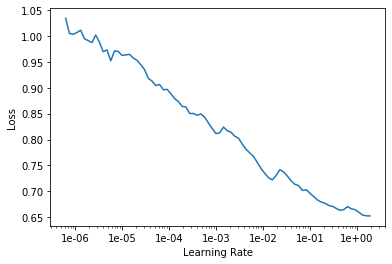

In [11]:
learn.lr_find()

learn.recorder.plot()

In [12]:
lr = 1e-4
learn.fit_one_cycle(1, max_lr=lr)
learn.save(f'{nb_name}.1a', with_opt=False)

epoch,train_loss,valid_loss,mse_loss,psnr,ssim,time
0,0.396355,0.373238,0.373238,12.652099,0.016698,03:10


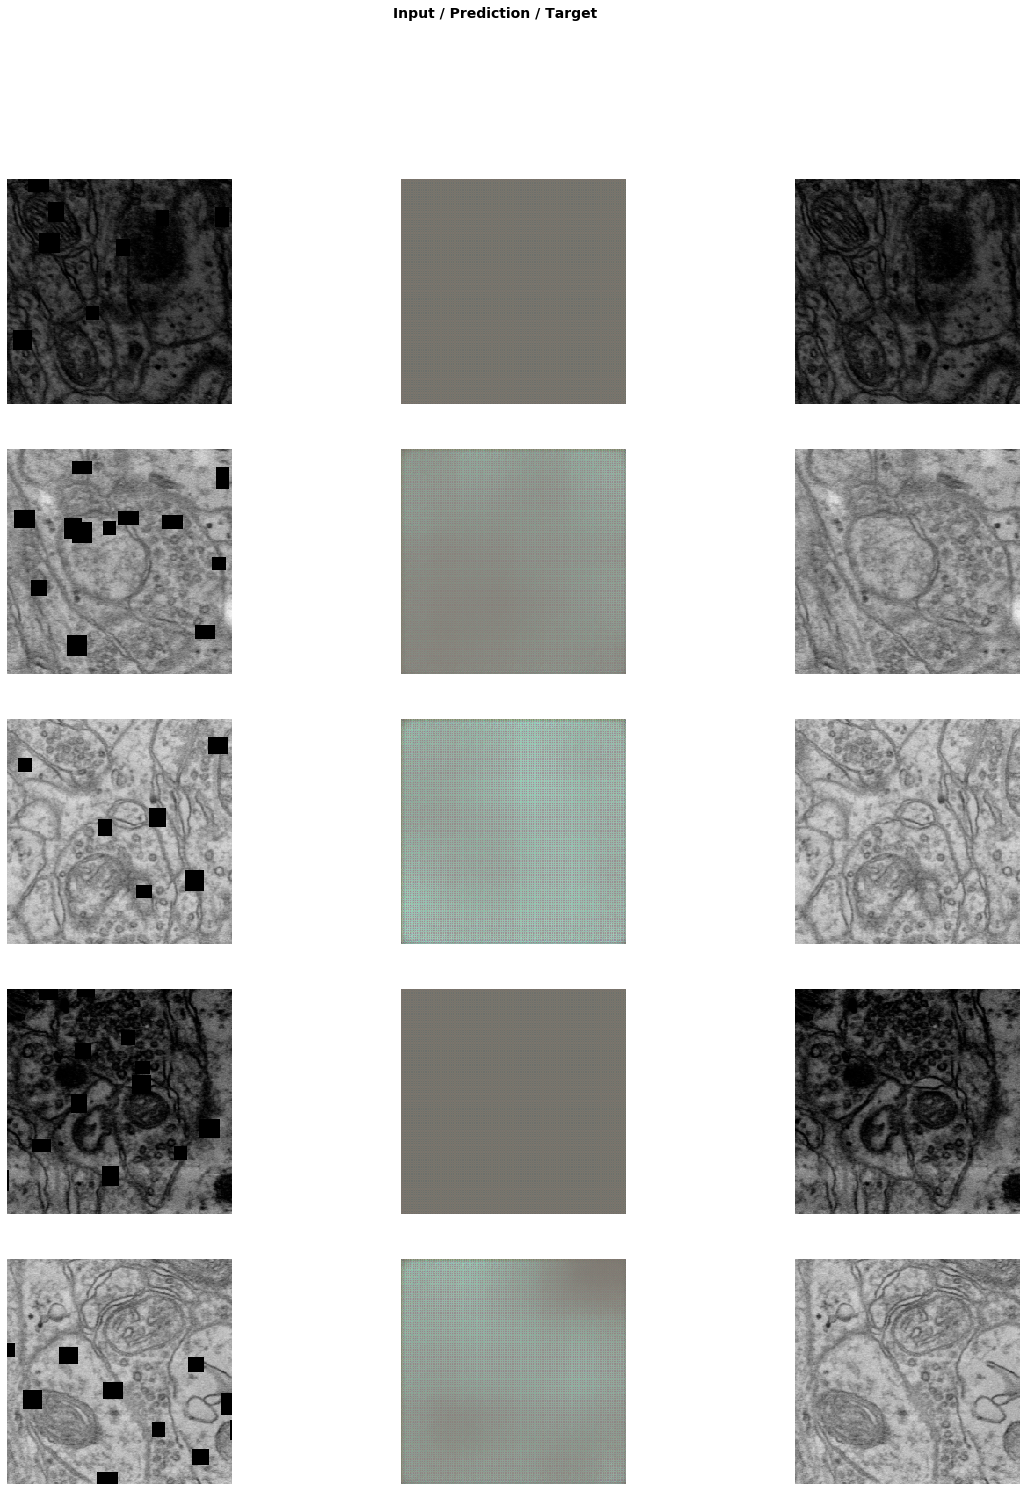

In [13]:
learn.show_results(rows=5, figsize=(20,24))

## 1b

In [14]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


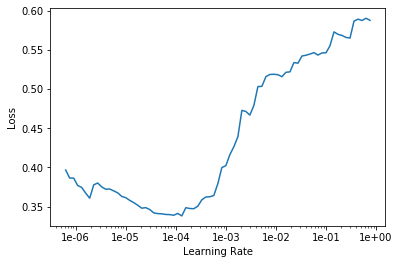

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
lr = slice(1e-5, 1e-3)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.1b', with_opt=False)

epoch,train_loss,valid_loss,mse_loss,psnr,ssim,time
0,0.240199,0.207699,0.207699,15.054653,0.047317,03:11
1,0.182873,0.169407,0.169407,15.950940,0.060245,03:14
2,0.158567,0.155056,0.155056,16.309025,0.066158,03:12


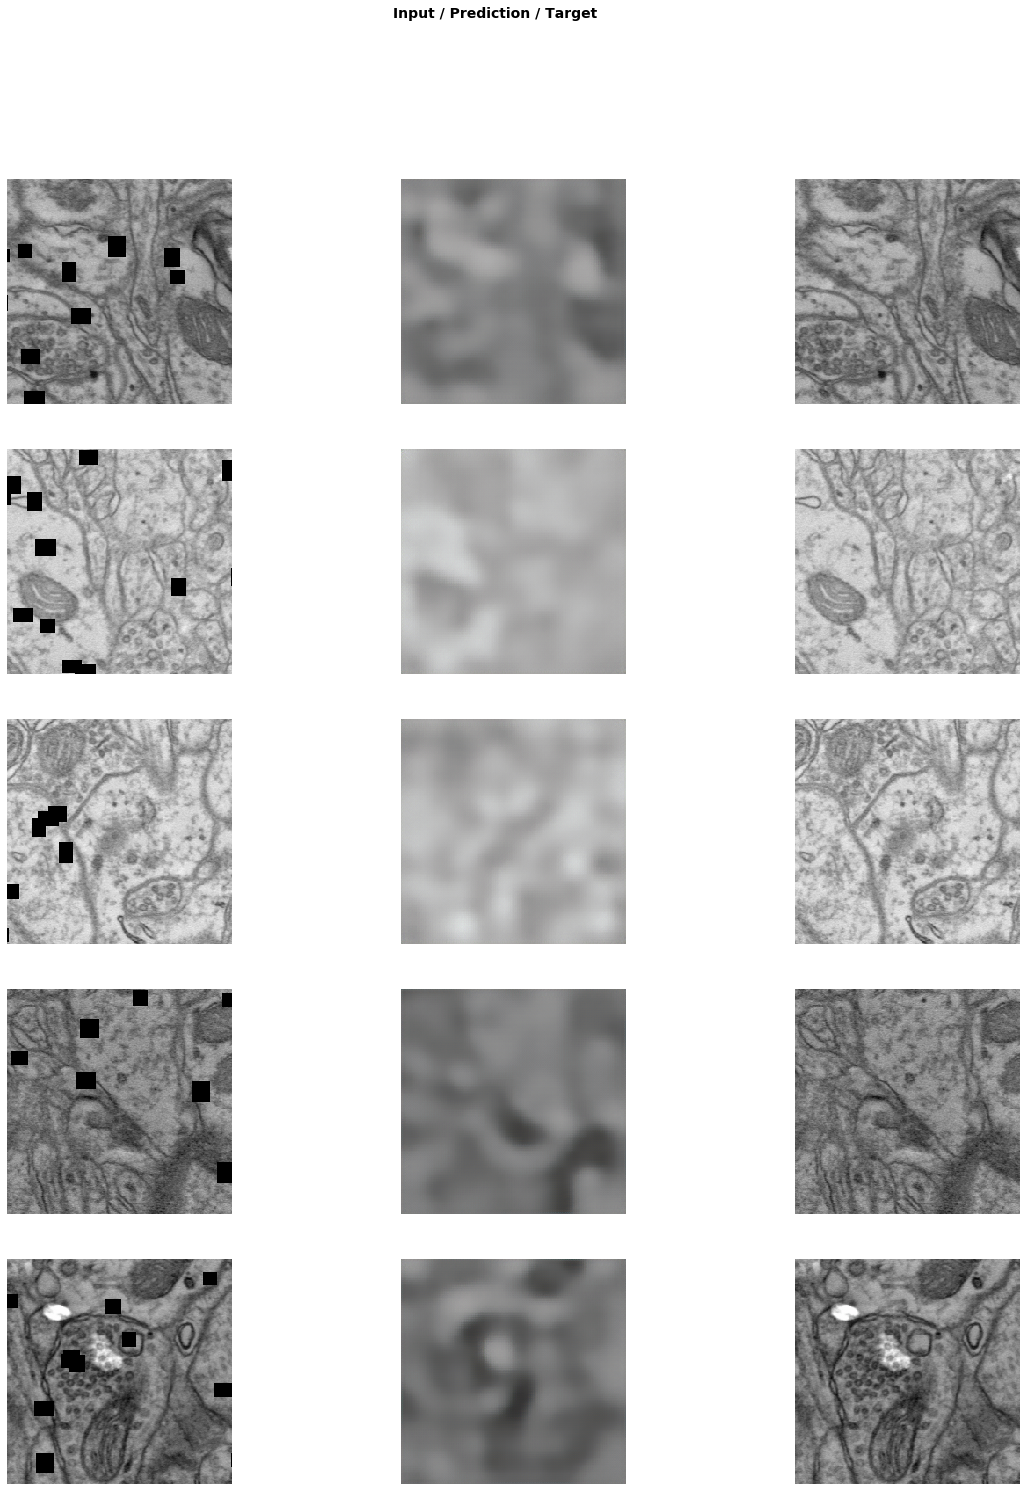

In [17]:
learn.show_results(rows=5, figsize=(20,24))

In [18]:
lr = slice(3e-6, 3e-4)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.1c', with_opt=False)

epoch,train_loss,valid_loss,mse_loss,psnr,ssim,time
0,0.162813,0.155417,0.155417,16.265066,0.068627,03:14
1,0.148206,0.141604,0.141604,16.671139,0.083100,03:12
2,0.142725,0.138931,0.138931,16.796791,0.083956,03:11


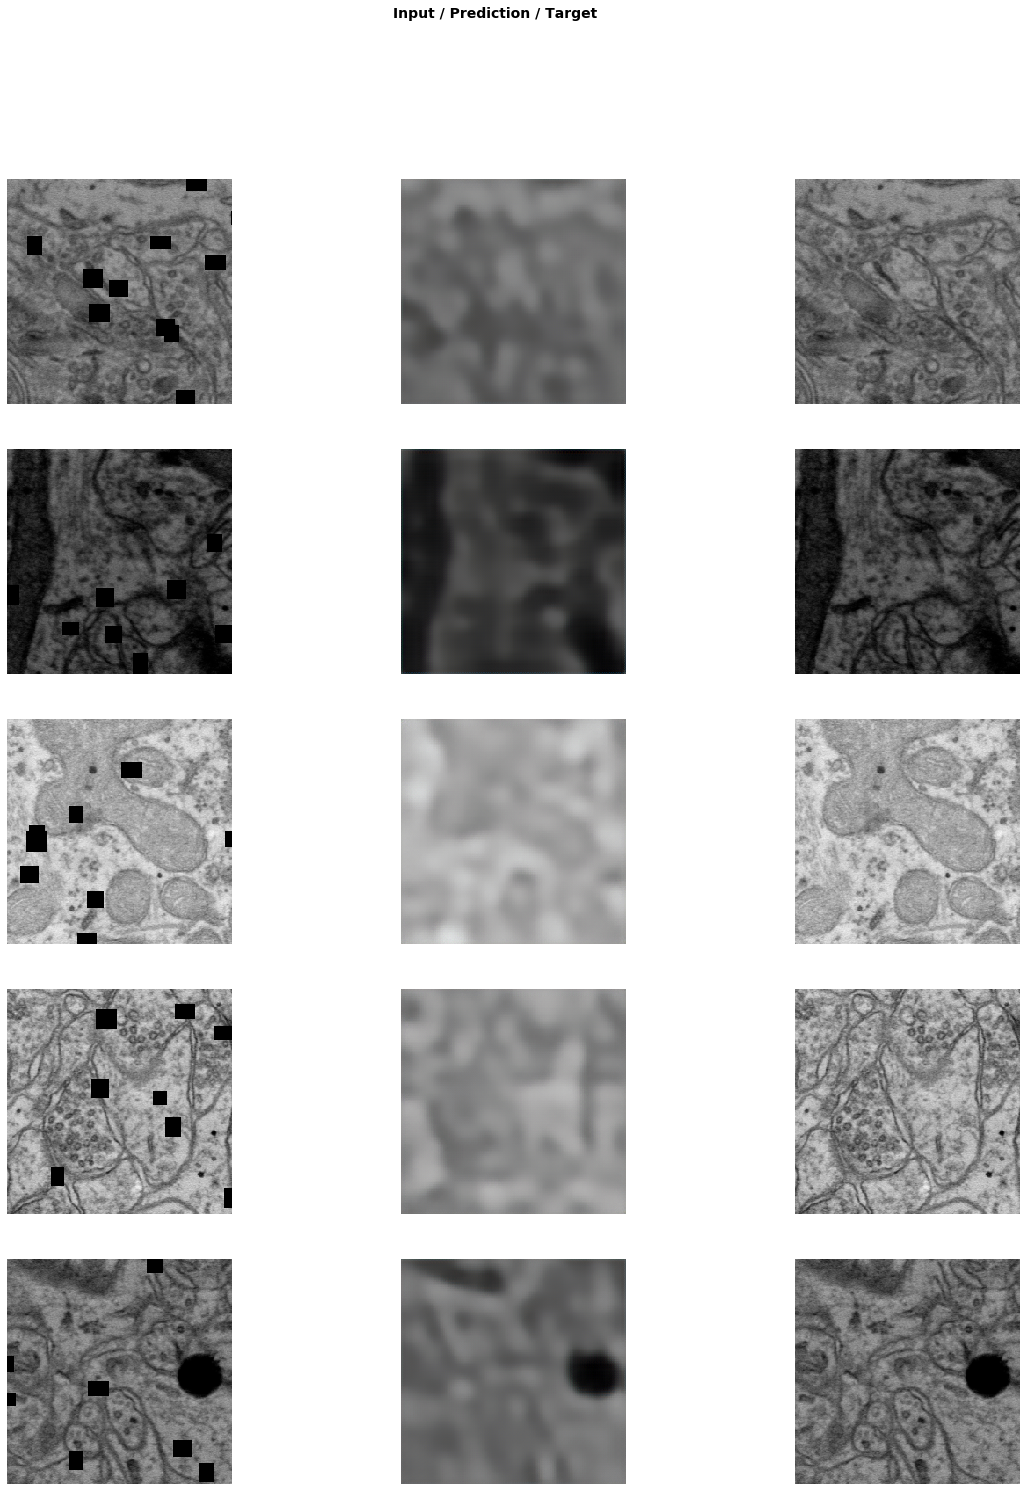

In [19]:
learn.show_results(rows=5, figsize=(20,24))

## Change Loss to MAE

In [20]:
learn.loss_func = F.l1_loss
learn.loss_func

<function torch.nn.functional.l1_loss(input, target, size_average=None, reduce=None, reduction='mean')>

In [21]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


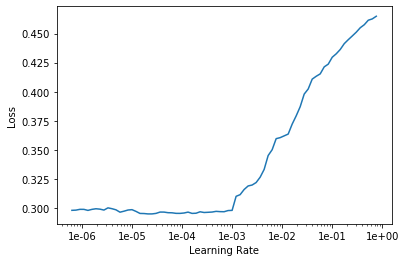

In [22]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = slice(3e-6, 3e-4)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.1d', with_opt=False)

epoch,train_loss,valid_loss,mse_loss,psnr,ssim,time
0,0.299060,0.295160,0.141286,16.699926,0.086137,03:15
1,0.290743,0.290959,0.139060,16.758308,0.091049,03:14


In [ ]:
learn.show_results(rows=5, figsize=(20,24))

In [ ]:
lr = slice(3e-5, 3e-3)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.1e', with_opt=False)

In [ ]:
learn.show_results(rows=5, figsize=(20,24))

In [ ]:
learn.loss_func = F.mse_loss
learn.loss_func

In [ ]:
lr = slice(3e-5, 3e-3)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.2f', with_opt=False)

In [ ]:
learn.show_results(rows=5, figsize=(20,24))

In [ ]:
lr = 1e-3
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.1g', with_opt=False)

In [ ]:
learn.show_results(rows=5, figsize=(20,24))